## Molecular MNIST dataset preparation

A constructed set of molecules is based on a clean-leads dataset collected from ZINC: http://zinc.docking.org/subsets/clean-leads. This dataset contains $4{,}591{,}276$ molecules obtained from the ZINC databes by retaining only molecules with molecular weight in range from 250 to 350 Daltons, the number of rotatable bonds not greater than 7, and XlogP less or equal to $3.5$.

We removed molecules containing charged atoms or atoms besides C, N, S, O, F, Cl, Br, H. We also removed molecules containing some substructures using medicinal chemistry filters and Pains. For final molecules we computed canonic SMILES along with logP, Synthetic Accessibility (SA) and Quantitative Estimation of Druglikeness (QED).

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from rdkit.Chem.PandasTools import LoadSDF, AddMoleculeColumnToFrame
from rdkit import Chem
from multiprocessing import Pool
import glob
import progressbar
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Retrieve Clean-Leads dataset from ZINC
! mkdir -p tmp_data/
! wget http://zinc.docking.org/db/bysubset/11/usual.sdf.csh -P tmp_data/
! cd tmp_data && csh usual.sdf.csh

In [3]:
mcf = pd.read_csv('../moses/metrics/mcf.csv')
pains = pd.read_csv('../moses/metrics/wehi_pains.csv', names=['smarts', 'names'])
joint_smarts = mcf.append(pains, sort=True)
filters = [Chem.MolFromSmarts(x) for x in joint_smarts['smarts'].values]
joint_smarts.head()

,names,smarts
0,MCF1,[#6]=&!@[#6]-[#6]#[#7]
1,MCF2,[#6]=&!@[#6]-[#16](=[#8])=[#8]
2,MCF3,[#6]=&!@[#6&!H0]-&!@[#6](=[#8])-&!@[#7]
3,MCF4,"[H]C([H])([#6])[F,Cl,Br,I]"
4,MCF5,[#6]1-[#8]-[#6]-1


In [18]:
def process_molecule(mol_row, allowed={'C','N','S','O','F','Cl','Br','H'}):
    id_ = mol_row[1]['ID']
    mol = mol_row[1]['ROMol']
    h_mol = Chem.AddHs(mol)
    for smarts in filters:
        if h_mol.HasSubstructMatch(smarts):
            return None
    if not all([atom.GetFormalCharge()==0 for atom in mol.GetAtoms()]):
        return None
    if not all([atom.GetSymbol() in allowed for atom in mol.GetAtoms()]):
        return None
    smiles = Chem.MolToSmiles(mol)
    if smiles is None or len(smiles) == 0:
        return None
    if Chem.MolFromSmiles(smiles) is None:
        return None
    return id_, smiles

In [ ]:
pool = Pool(16)
with open('tmp_data/mcf_dataset.csv', 'w') as f:
    f.write('ID,SMILES\n')
    for filename in sorted(glob.glob('tmp_data/*.sdf.gz')):
        print('Processing {}'.format(filename))
        mols = LoadSDF(filename)
        bar = progressbar.ProgressBar(max_value=len(mols))
        for res in bar(pool.imap(process_molecule, mols.iterrows())):
            if res is None:
                continue
            f.write('{0},{1}\n'.format(*res))

### Splitting the dataset

In [2]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_n_rings(mol):
    return mol.GetRingInfo().NumRings()

def compute_scaffold(smiles, min_rings=2):
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    n_rings = get_n_rings(scaffold)
    scaffold_smiles = Chem.MolToSmiles(scaffold)
    if scaffold_smiles == '' or n_rings < min_rings:
        return None
    else:
        return scaffold_smiles

In [3]:
dataset = pd.read_csv('tmp_data/mcf_dataset.csv')
dataset = dataset.drop_duplicates('SMILES')
dataset.head()

,ID,SMILES
0,ZINC50764925,CCCCNC(=O)C1CCCN(C(=O)CCC(C)C)C1
1,ZINC65292537,Cc1ccccc1C(=O)N1CCC(Cc2nc3cccnc3n2C)C1
2,ZINC31820077,CCc1c(C(=O)N2CCC(C(=O)NC)CC2)cnn1-c1ccccn1
3,ZINC65513427,CC(=O)Nc1ccc2nc(NC(=O)C3CC3c3ccco3)sc2c1
4,ZINC02782238,CCn1cc(C(=O)Nc2cn(CC)nc2C(N)=O)c(C)n1


,ID,SMILES,ROMol
0,ZINC50764925,CCCCNC(=O)C1CCCN(C(=O)CCC(C)C)C1,
1,ZINC65292537,Cc1ccccc1C(=O)N1CCC(Cc2nc3cccnc3n2C)C1,

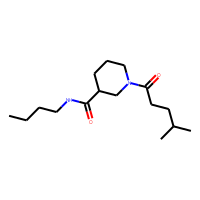
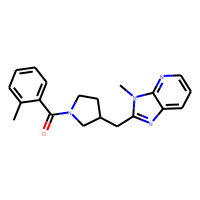

In [4]:
df = dataset.head(2).copy()
AddMoleculeColumnToFrame(df, smilesCol='SMILES')
df

In [5]:
pool = Pool(16)
dataset['scaffold'] = pool.map(compute_scaffold, dataset['SMILES'].values)
pool.close()

In [6]:
scaffolds = pd.value_counts(dataset['scaffold'])
scaffolds = sorted(scaffolds.items(), key=lambda x: (-x[1], x[0]))

In [7]:
dataset.head()

,ID,SMILES,scaffold
0,ZINC50764925,CCCCNC(=O)C1CCCN(C(=O)CCC(C)C)C1,None
1,ZINC65292537,Cc1ccccc1C(=O)N1CCC(Cc2nc3cccnc3n2C)C1,O=C(c1ccccc1)N1CCC(Cc2nc3cccnc3[nH]2)C1
2,ZINC31820077,CCc1c(C(=O)N2CCC(C(=O)NC)CC2)cnn1-c1ccccn1,O=C(c1cnn(-c2ccccn2)c1)N1CCCCC1
3,ZINC65513427,CC(=O)Nc1ccc2nc(NC(=O)C3CC3c3ccco3)sc2c1,O=C(Nc1nc2ccccc2s1)C1CC1c1ccco1
4,ZINC02782238,CCn1cc(C(=O)Nc2cn(CC)nc2C(N)=O)c(C)n1,O=C(Nc1cn[nH]c1)c1cn[nH]c1


In [8]:
test_scaffolds = set([x[0] for x in scaffolds[9::10]])
dataset['split'] = 'train'
def f(x):
    return x in test_scaffolds
pool = Pool(16)
test_scaf_idx = pool.map(f, dataset['scaffold'])
pool.close()
dataset.loc[test_scaf_idx, 'split'] = 'test_scaffolds'
test_idx = dataset.loc[dataset['split'] == 'train'].sample(frac=0.1, random_state=777).index
dataset.loc[test_idx, 'split'] = 'test'

In [9]:
pd.value_counts(dataset['split'])

train             1760707
test_scaffolds     197258
test               195634
Name: split, dtype: int64

In [10]:
dataset.drop('scaffold', axis=1, inplace=True)

## Saving final dataset

In [11]:
dataset.to_csv('mcf_dataset_splitted.csv', index=None)

In [ ]:
# ! rm -r tmp_data/